In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [2]:
# This cell can be used to pull the feature and target data already seperated directly from UC Irvines website
from ucimlrepo import fetch_ucirepo

# fetch dataset 
poker_hand = fetch_ucirepo(id=158) 
  
# data (as pandas dataframes) 
X = poker_hand.data.features 
y = poker_hand.data.targets

In [ ]:
# Merge features and target data into one pandas dataframe
poker_data = pd.concat([X,y], axis=1)

In [ ]:
# Export poker_data df as a csv 
poker_data.to_csv('Resources/poker_data.csv', index=False)

In [ ]:
from sqlalchemy import create_engine
import psycopg2
from config import engine_key

In [ ]:
# Create the engine and connection to our SQL database
engine = create_engine(f'postgresql+psycopg2://{engine_key}')
conn = engine.raw_connection()

In [15]:
# Query All Records in the the Database
poker_df = pd.read_sql("SELECT * FROM poker_data", conn)

/var/folders/v7/5k7l4pvx71x5y320bb9xhjpw0000gn/T/ipykernel_6514/1424010739.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  poker_df = pd.read_sql("SELECT * FROM poker_data", conn)


In [ ]:
# Close the connection after use
conn.close()

In [ ]:
# Check to see if data has been pulled from SQL into pandas df 
poker_df.head()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,CLASS
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


In [3]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# Define the model pipeline
# List of categorical columns to one-hot encode
suits_columns = ['S1', 'S2', 'S3', 'S4', 'S5']
ranks_columns = ['C1', 'C2', 'C3', 'C4', 'C5']


In [5]:
# Combine suit and rank columns into one list for one-hot encoding
categorical_columns = suits_columns + ranks_columns

In [6]:
# Define a ColumnTransformer to apply OneHotEncoding to the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # Leave the target column as is
)

In [7]:
# Create the full pipeline with preprocessor and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [8]:
# Train the model
model.fit(X_train, y_train.to_numpy().ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['S1', 'S2', 'S3', 'S4', 'S5',
                                                   'C1', 'C2', 'C3', 'C4',
                                                   'C5'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [9]:
# Make predictions
y_pred = model.predict(X_test)

In [10]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9183


In [11]:
# Classification report to see more info on accuarcy and efficiency 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    153717
           1       0.86      0.98      0.92    130369
           2       0.83      0.01      0.02     14545
           3       0.88      0.19      0.31      6524
           4       1.00      0.00      0.01      1203
           5       1.00      0.01      0.01       611
           6       1.00      0.01      0.02       446
           7       0.00      0.00      0.00        81
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         3

    accuracy                           0.92    307503
   macro avg       0.65      0.22      0.23    307503
weighted avg       0.92      0.92      0.89    307503



/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# Create the full pipeline with preprocessor and model this time using balanced class weight to assign heigher weights to minority classes
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])


In [ ]:
#Train the model
model.fit(X_train, y_train.to_numpy().ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['S1', 'S2', 'S3', 'S4', 'S5',
                                                   'C1', 'C2', 'C3', 'C4',
                                                   'C5'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8205


In [16]:
# Classification report to see more info on accuarcy and efficiency 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90    153717
           1       0.81      0.77      0.79    130369
           2       0.81      0.01      0.01     14545
           3       0.78      0.03      0.06      6524
           4       1.00      0.00      0.00      1203
           5       0.99      0.99      0.99       611
           6       1.00      0.00      0.00       446
           7       0.00      0.00      0.00        81
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         3

    accuracy                           0.82    307503
   macro avg       0.62      0.28      0.28    307503
weighted avg       0.82      0.82      0.79    307503



/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


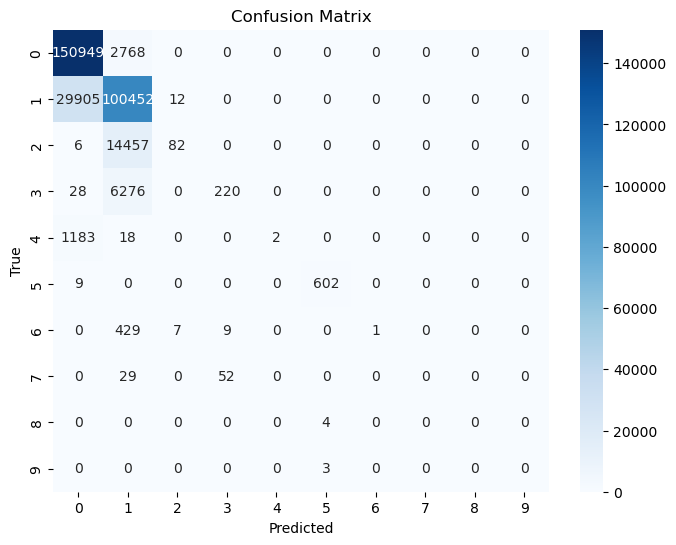

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [3]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestRegressor
# List of categorical columns (e.g., suits and ranks)
categorical_columns = ['S1', 'S2', 'S3', 'S4', 'S5', 'C1', 'C2', 'C3', 'C4', 'C5']

# Create the column transformer with one-hot encoding for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # Keep non-categorical columns (if any) as they are
)

# Create the pipeline with the preprocessor and RandomForestRegressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [ ]:
# Fit the model to the training data
model.fit(X_train, y_train.to_numpy().ravel())


In [ ]:
# Predict the chance of winning on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
